# Prophet 라이브러리

메타(페이스북)에서 발표한 시계열 분석 머신러닝 라이브러리

`prophet` 라이브러리의 설치가 필요하다.

> https://facebook.github.io/prophet/

> https://peerj.com/preprints/3190.pdf

## #01. 준비작업

### [1] 패키지 참조

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

from hossam.util import *
from hossam.plot import *
from hossam.timeserise import *

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_squared_error

### [2] 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/tsdata/air_passengers.xlsx")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB
None

데이터프레임 상위 5개 행
+----+---------------------+--------------+
|    | Month               |   Passengers |
|----+---------------------+--------------|
|  0 | 1949-01-01 00:00:00 |          112 |
|  1 | 1949-02-01 00:00:00 |          118 |
|  2 | 1949-03-01 00:00:00 |          132 |
|  3 | 1949-04-01 00:00:00 |          129 |
|  4 | 1949-05-01 00:00:00 |          121 |
+----+---------------------+--------------+

데이터프레임 하위 5개 행
+-----+---------------------+--------------+
|     | Month               |   Passengers |
|-----+---------------------+--------------|
| 139 | 1960-08-01 00:00:00 |          606 |
| 140 | 1960-09-01 00:00:00 |     

## #02. 데이터 전처리

### [1] 데이터 프레임의 필드 이름 변경

prophet 라이브러리의 요구사항에 따라 날짜 필드의 이름을 `ds`로, 데이터의 필드 이름을 `y`로 변경해야 한다.

날짜의 데이터 타입은 `datetime` 형식이어야 한다.

> 날짜 변수가 인덱스가 아님에 유의

In [3]:
df = origin.rename(columns={'Month': 'ds', 'Passengers': 'y'})
my_pretty_table(df.head())

+----+---------------------+-----+
|    | ds                  |   y |
|----+---------------------+-----|
|  0 | 1949-01-01 00:00:00 | 112 |
|  1 | 1949-02-01 00:00:00 | 118 |
|  2 | 1949-03-01 00:00:00 | 132 |
|  3 | 1949-04-01 00:00:00 | 129 |
|  4 | 1949-05-01 00:00:00 | 121 |
+----+---------------------+-----+


### [2] 데이터 분할

In [4]:
train, test = my_timeseries_split(df)
train.shape, test.shape

((115, 2), (29, 2))

## #03. 시계열 학습 모델 구현

### [1] 모델 정의 및 학습

In [5]:
m = Prophet()
m.fit(train)

15:03:15 - cmdstanpy - INFO - Chain [1] start processing
15:03:15 - cmdstanpy - INFO - Chain [1] done processing


### [2] 학습결과를 활용하여 예측

`periods`는 예측할 기간 (일(`D`), 월(`M`) 단위 설정 가능 / 기본은 일단위)

In [6]:
future = m.make_future_dataframe(periods=len(test), freq='M')
forecast = m.predict(future)
my_pretty_table(forecast.head())

+----+---------------------+---------+--------------+--------------+---------------+---------------+------------------+------------------------+------------------------+----------+----------------+----------------+------------------------+------------------------------+------------------------------+---------+
|    | ds                  |   trend |   yhat_lower |   yhat_upper |   trend_lower |   trend_upper |   additive_terms |   additive_terms_lower |   additive_terms_upper |   yearly |   yearly_lower |   yearly_upper |   multiplicative_terms |   multiplicative_terms_lower |   multiplicative_terms_upper |    yhat |
|----+---------------------+---------+--------------+--------------+---------------+---------------+------------------+------------------------+------------------------+----------+----------------+----------------+------------------------+------------------------------+------------------------------+---------|
|  0 | 1949-01-01 00:00:00 | 109.271 |      68.9804 |      109.6

### [3] 예측 결과에 대한 시각화

- 검은색 점 : 실 데이터
- 파란색 선 : 모델이 예측한 데이터

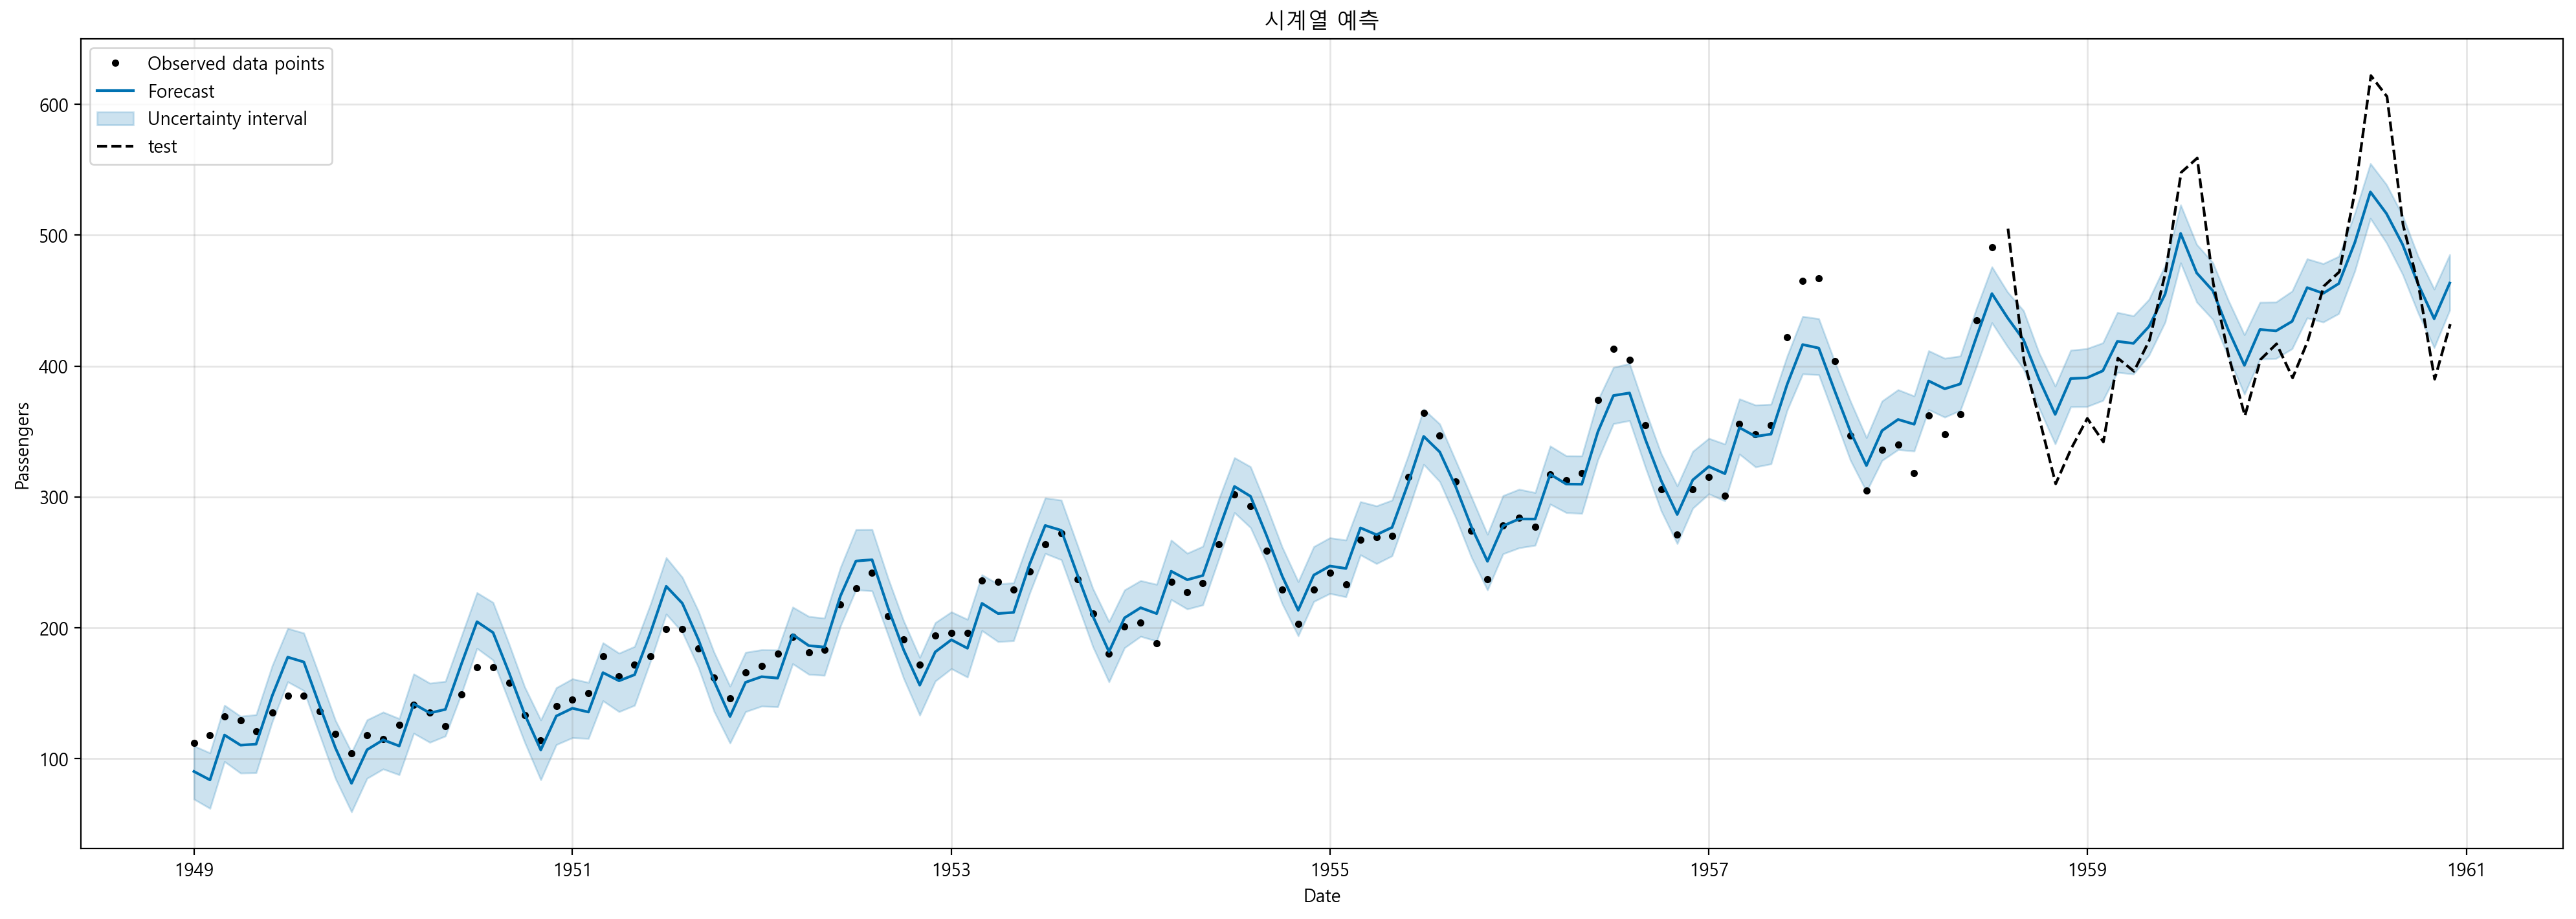

In [7]:
fig = m.plot(forecast, figsize=(20, 7), xlabel='Date', ylabel='Passengers', uncertainty=True)
ax = fig.gca()
ax.set_title("시계열 예측")

sb.lineplot(data=test, x='ds', y='y', ax=ax, color='black', linestyle="--", label='test')

plt.show()
plt.close()

### [4] 모델이 갖는 컴포넌트 확인 (성분분해)

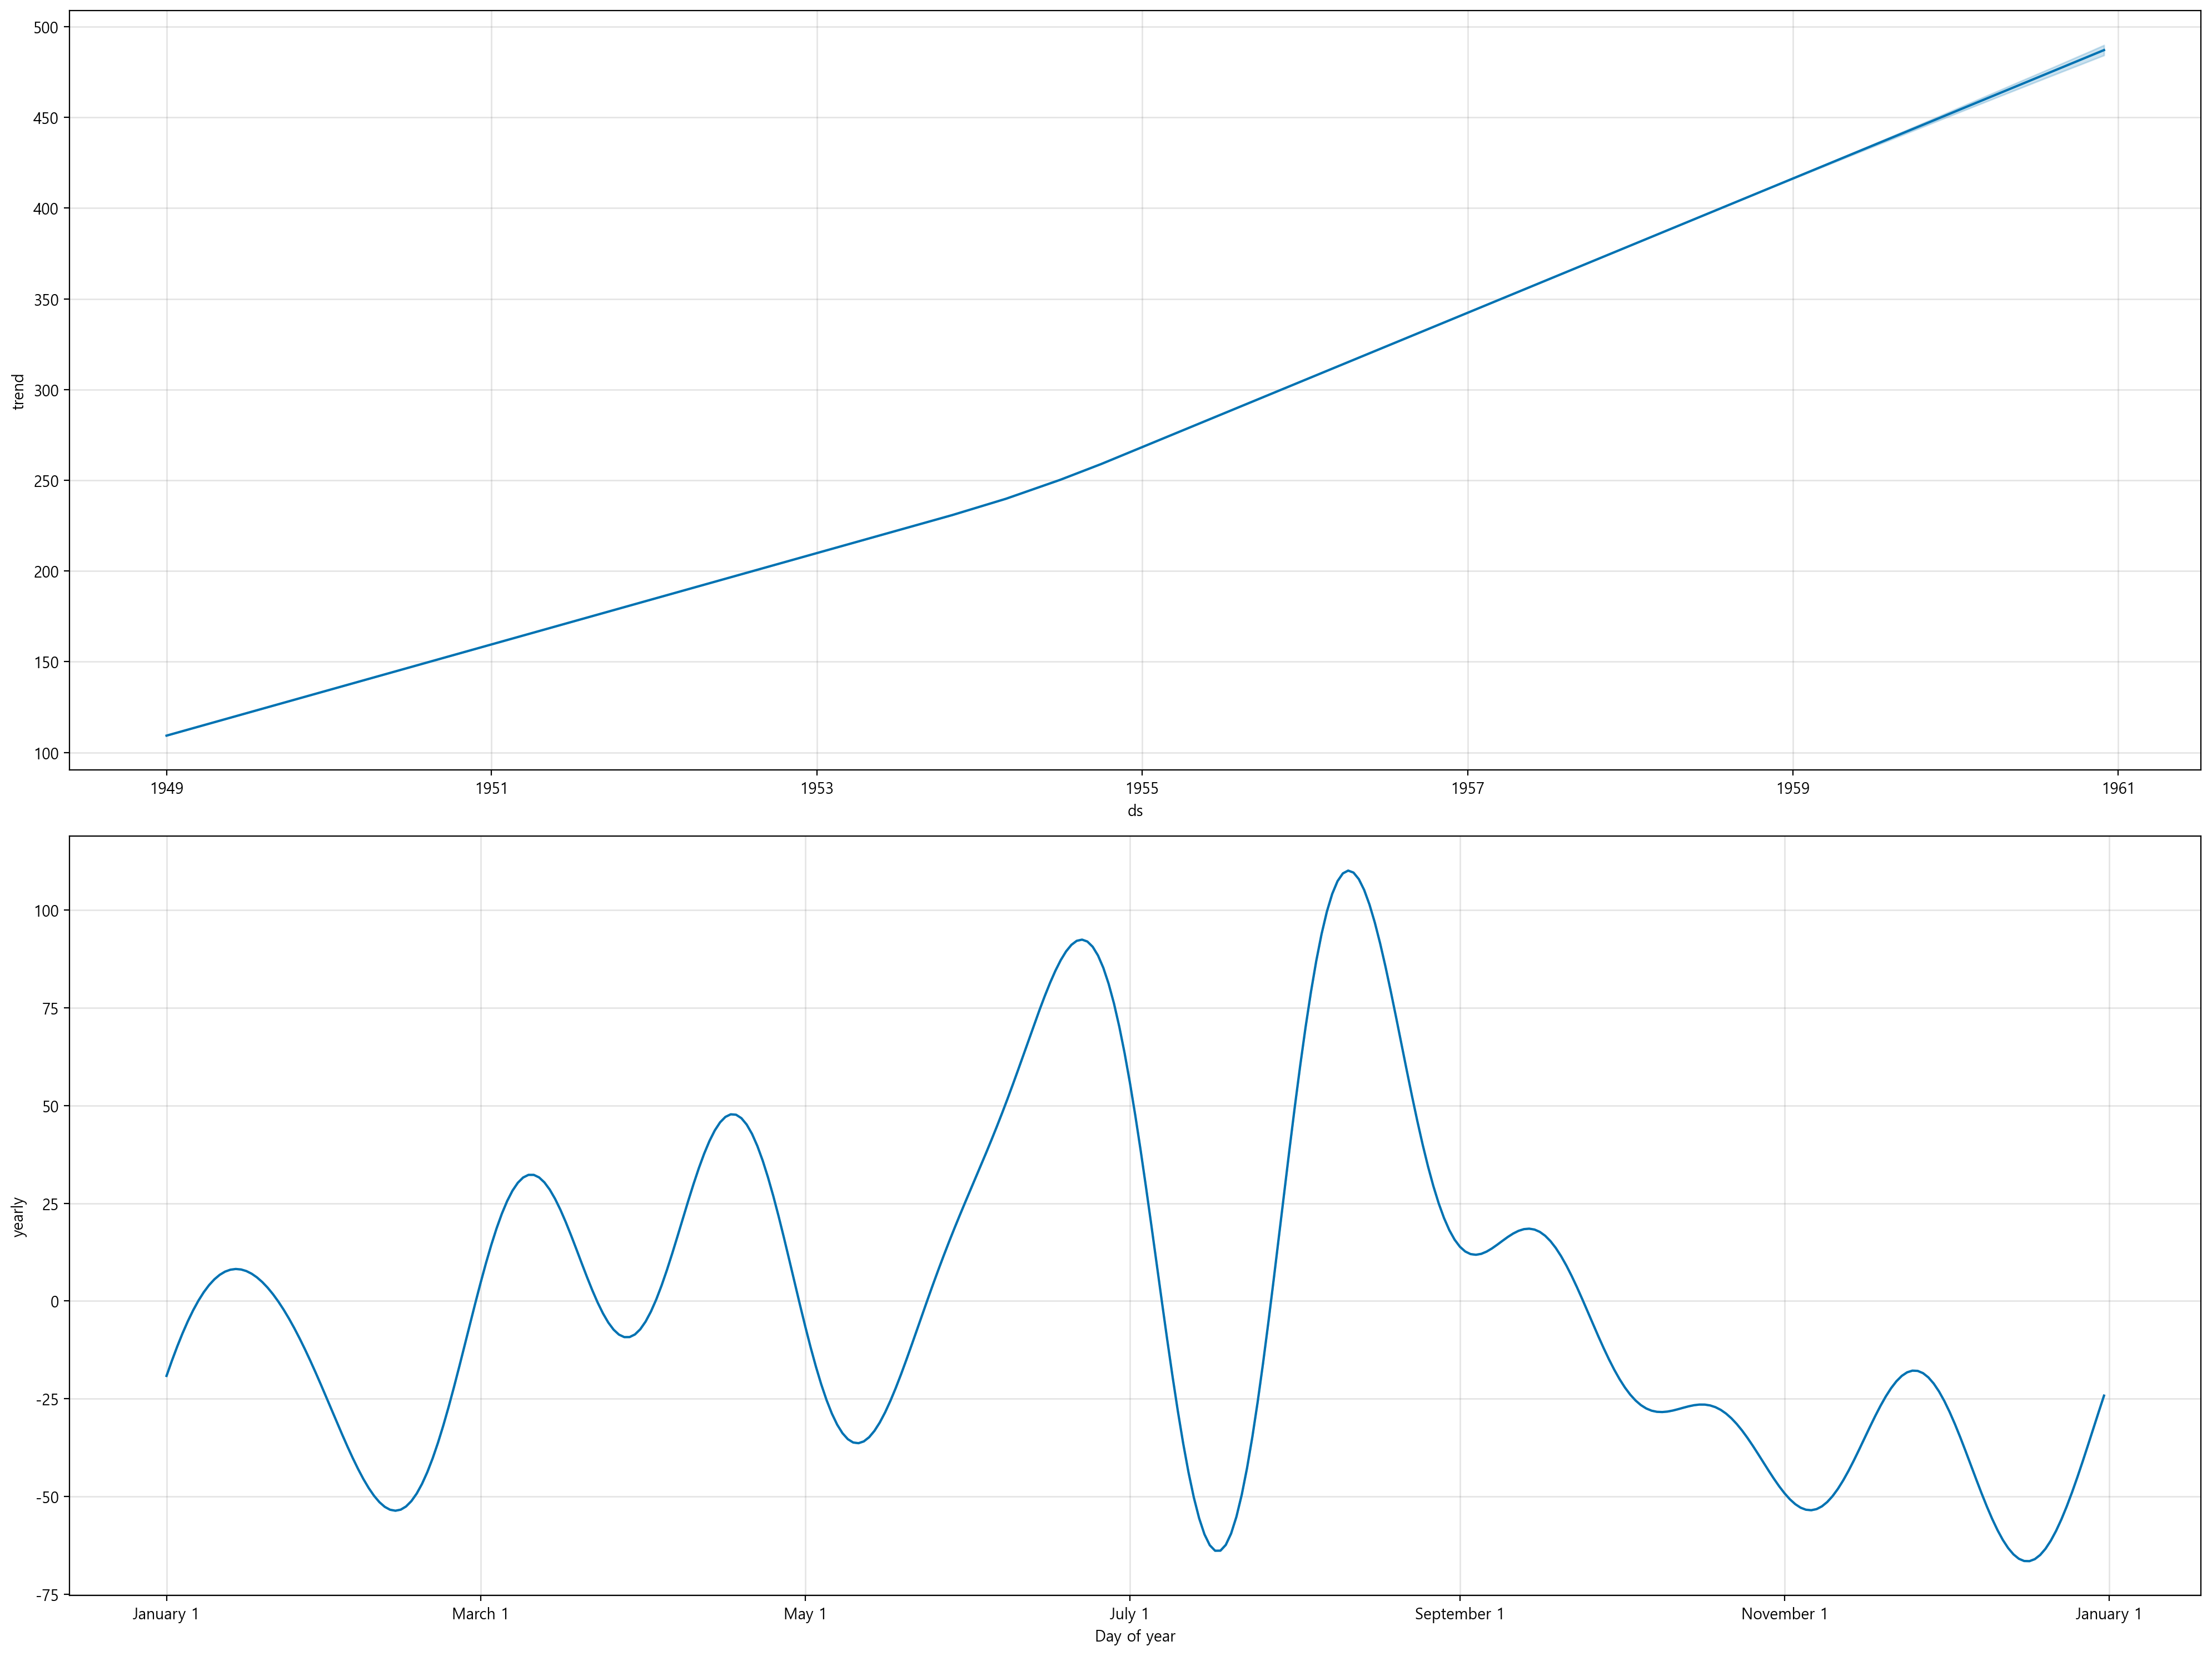

In [8]:
fig = m.plot_components(forecast, figsize=(20, 15))
ax = fig.gca()
plt.show()
plt.close()

### [5] changepoint 를 추가한 시각화

`changepoint` - Trend가 변화하는 지점

- fig.gca() : 시계열 그래프
- m : 미리 만들어준 Prophet 객체
- forecast : predict 결과

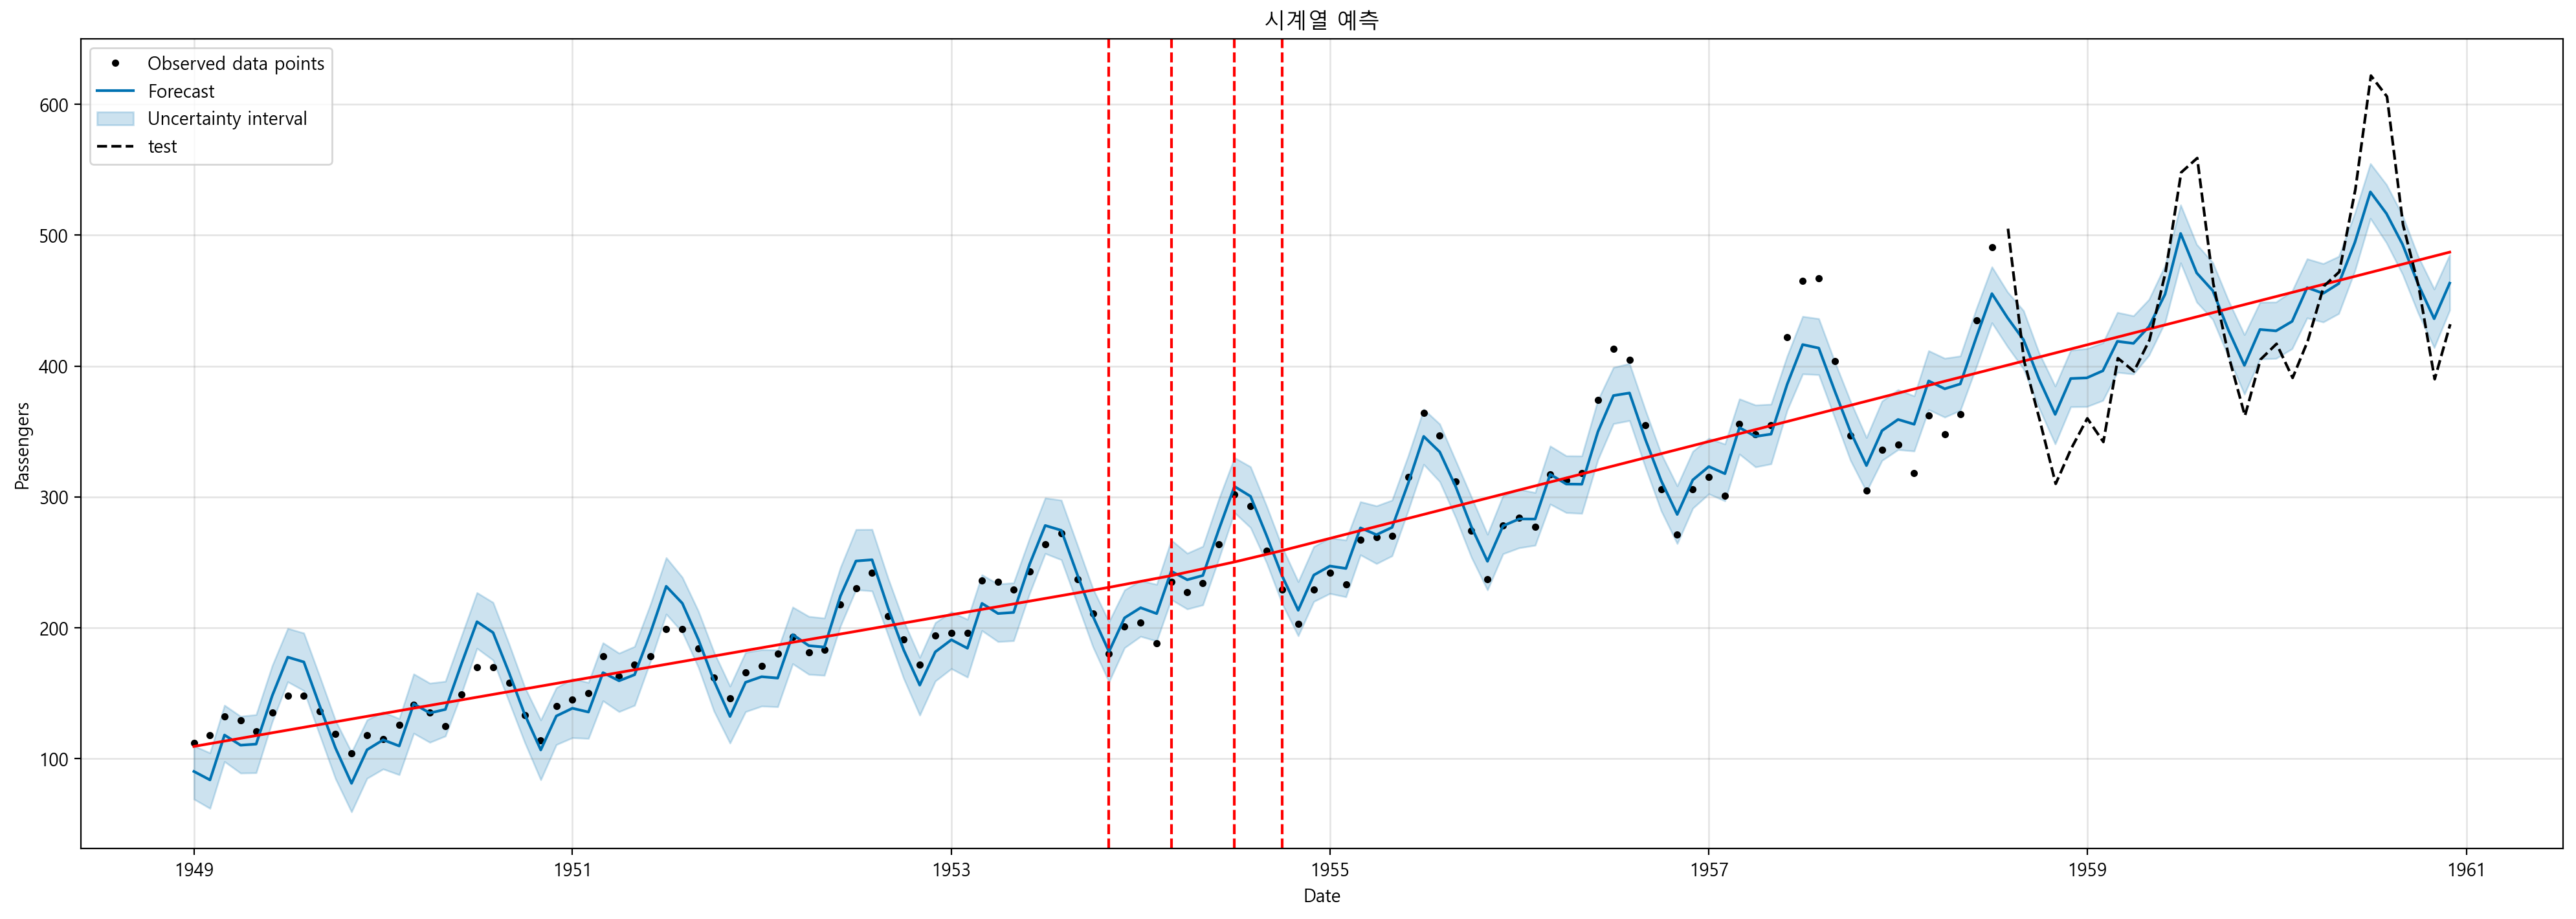

In [9]:
fig = m.plot(forecast, figsize=(20, 7), xlabel='Date', ylabel='Passengers', uncertainty=True)
ax = fig.gca()
add_changepoints_to_plot(ax, m, forecast)

ax.set_title("시계열 예측")
sb.lineplot(data=test, x='ds', y='y', ax=ax, color='black', linestyle="--", label='test')

plt.show()
plt.close()

> 빨간색 실선 : 트랜드 / 빨간색 점선 : 트랜드가 변화하는 changepoint

## #04. 성능평가

In [10]:
yhat = forecast['yhat'].values[-len(test):]
yhat

array([436.99484773, 420.0581809 , 389.92781946, 363.07251207,
       390.48277296, 390.9762683 , 396.39196635, 418.90488255,
       417.34729316, 430.2437194 , 454.95681218, 501.35630683,
       471.18153314, 457.62480187, 427.56157787, 400.53088589,
       427.97863087, 426.9120459 , 434.15959968, 459.9746224 ,
       455.59802216, 463.0759328 , 494.46178246, 533.11144267,
       516.57083962, 493.04609167, 462.70686093, 436.18957876,
       463.41153093])

In [13]:
y = test['y'].values
y

array([505, 404, 359, 310, 337, 360, 342, 406, 396, 420, 472, 548, 559,
       463, 407, 362, 405, 417, 391, 419, 461, 472, 535, 622, 606, 508,
       461, 390, 432], dtype=int64)

In [12]:
result = {
    "평균절대오차(MAE)": mean_absolute_error(y, yhat),
    "평균제곱오차(MSE)": mean_squared_error(y, yhat),
    "평균오차(RMSE)": np.sqrt(mean_squared_error(y, yhat))
}

my_pretty_table(DataFrame(result, index=["Prophet"]).T)

+-------------------+-----------+
|                   |   Prophet |
|-------------------+-----------|
| 평균절대오차(MAE) |   34.8915 |
| 평균제곱오차(MSE) |   1842.81 |
| 평균오차(RMSE)    |   42.9279 |
+-------------------+-----------+
